In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11733823440009470047
]


In [4]:
import os
import math
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
tf.__version__

'2.0.0-beta0'

In [6]:
# return gray image
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [7]:
# training targets, you can use your custome csv file if you already created it with "training-sample.py"
targets = pd.Series.from_csv('data_csv/jester-v1-train.csv',header=None,sep = ";").to_dict()
targets[34870]
# validation targets, you can use your custome csv file if you already created it with "validation-sample.py"
targets_validation = pd.Series.from_csv('data_csv/jester-v1-validation.csv',header=None,sep = ";").to_dict()
targets_validation[9223]

C:\Users\UCA\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


'Thumb Up'

In [8]:
len(targets)
targets[100000]

'Thumb Up'

In [9]:
# classes label you want to use all labels 
'''label = pd.read_csv('data_csv/labels.csv',header=None, usecols=[0])
label.head()
targets_name = label[0].tolist()
len(targets_name)'''

# The classes (labels) we want to use
targets_name = [
    "Swiping Right",
    "Sliding Two Fingers Left",
    "No gesture",
    "Thumb Up"
    ]

In [11]:
# Get the data directories
path = "training_samples/"
path_cv = "validation_samples/"

dirs = os.listdir(path)
dirs_cv = os.listdir(path_cv)

In [12]:
# number of samples for training and validation
print(len(dirs))
print(len(dirs_cv))

6000
1971


In [13]:
training_count = 10


In [14]:
'''
The videos do not have the same number of frames, here we try to unify.
'''
hm_frames = 30 # number of frames
# unify number of frames for each training
def get_unify_frames(path):
    offset = 0
    # pick frames
    frames = os.listdir(path)
    frames_count = len(frames)
    # unify number of frames 
    if hm_frames > frames_count:
        # duplicate last frame if video is shorter than necessary
        frames += [frames[-1]] * (hm_frames - frames_count)
    elif hm_frames < frames_count:
        # If there are more frames, then sample starting offset
        #diff = (frames_count - hm_frames)
        #offset = diff-1 
        frames = frames[0:hm_frames]
    return frames  

In [15]:
# Resize frames
def resize_frame(frame):
    frame = img.imread(frame)
    frame = cv2.resize(frame, (64, 64))
    return frame
    

In [16]:
# Adjust training data
counter_training = 0 # number of training
training_targets = [] # training targets 
new_frames = [] # training data after resize & unify
for directory in dirs:
    new_frame = [] # one training
    # Frames in each folder
    frames = get_unify_frames(path+directory)
    if len(frames) == hm_frames: # just to be sure
        for frame in frames:
            frame = resize_frame(path+directory+'/'+frame)
            new_frame.append(rgb2gray(frame))
            if len(new_frame) == 15: # partition each training on two trainings.
                new_frames.append(new_frame) # append each partition to training data
                training_targets.append(targets_name.index(targets[int(directory)]))
                counter_training +=1
                new_frame = []

In [17]:
# we do the same for the validation data
counter_validation = 0
cv_targets = []
new_frames_cv = []
for directory in dirs_cv:
    new_frame = []
    # Frames in each folder
    frames = get_unify_frames(path_cv+directory)
    if len(frames)==hm_frames:
        for frame in frames:
            frame = resize_frame(path_cv+directory+'/'+frame)
            new_frame.append(rgb2gray(frame))
            if len(new_frame) == 15:
                new_frames_cv.append(new_frame)
                cv_targets.append(targets_name.index(targets_validation[int(directory)]))
                counter_validation +=1
                new_frame = []

In [18]:
# To check training length
print(len(new_frames))
print(len(training_targets))

12000
12000


In [19]:
# To check validation length
print(len(new_frames_cv))
print(len(cv_targets))

3942
3942


In [20]:
training_targets[0:20]

[0, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 0, 0, 3, 3, 3, 3]

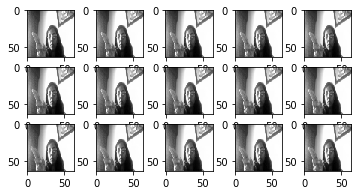

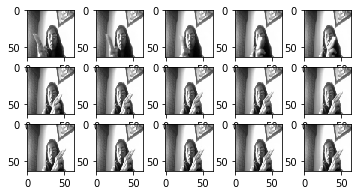

<Figure size 432x288 with 0 Axes>

In [21]:
#show data
fig = plt.figure()
for i in range(2,4):
    for num,frame in enumerate(new_frames[i][0:18]):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(frame, cmap='gray')
    fig = plt.figure()
plt.show()

In [22]:
# convert training data to np float32
training_data = np.array(new_frames[0:counter_training], dtype=np.float32)

In [23]:
# Function to empty the RAM
def release_list(a):
   del a[:]
   del a

In [24]:
release_list(new_frames)

In [26]:
# convert validation data to np float32
cv_data = np.array(new_frames_cv[0:counter_validation], dtype=np.float32)

In [27]:
release_list(new_frames_cv)

In [25]:
training_data.shape

(12000, 15, 64, 64)

In [28]:
cv_data.shape

(3942, 15, 64, 64)

In [29]:
# Normalisation: training
print('old mean', training_data.mean())
scaler = StandardScaler()
scaled_images  = scaler.fit_transform(training_data.reshape(-1, 15*64*64))
print('new mean', scaled_images.mean())
scaled_images  = scaled_images.reshape(-1, 15, 64, 64, 1)
print(scaled_images.shape)

109.7265
2.8716194e-09
(12000, 15, 64, 64, 1)


In [30]:
# Normalisation: validation
print('old mean', cv_data.mean())
scaler = StandardScaler()
scaled_images_cv  = scaler.fit_transform(cv_data.reshape(-1, 15*64*64))
print('new mean',scaled_images_cv.mean())
scaled_images_cv  = scaled_images_cv.reshape(-1, 15, 64, 64, 1)
print(scaled_images_cv.shape)

107.52739
-1.1727388e-08
(3942, 15, 64, 64, 1)


In [32]:
# My model
class Conv3DModel(tf.keras.Model):
  def __init__(self):
    super(Conv3DModel, self).__init__()
    # Convolutions
    self.conv1 = tf.compat.v2.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv2 = tf.compat.v2.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2,2), data_format='channels_last')
   
    # LSTM & Flatten
    self.convLSTM =tf.keras.layers.ConvLSTM2D(40, (3, 3))
    self.flatten =  tf.keras.layers.Flatten(name="flatten")

    # Dense layers
    self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
    self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")
    

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.convLSTM(x)
    #x = self.pool2(x)
    #x = self.conv3(x)
    #x = self.pool3(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.out(x)

## 1. the simplest method with beginner syntax

In [33]:
model = Conv3DModel()

In [ ]:
# choose the loss and optimizer methods
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [35]:
x_train = np.array(scaled_images)
y_train = np.array(training_targets)
x_val = np.array(scaled_images_cv)
y_val = np.array(cv_targets)

In [36]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(12000, 15, 64, 64, 1)
(12000,)
(3942, 15, 64, 64, 1)
(3942,)


#### here I use the checkpoints
read more:
https://www.tensorflow.org/beta/guide/checkpoints

In [37]:
# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "training_today/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
# Run the training 
history = model.fit(x_train, y_train,
                    callbacks = [cp_callback],
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=10)

In [39]:
# just after one epoch
history.history

{'loss': [0.7653240595261256],
 'accuracy': [0.69325],
 'val_loss': [0.49401697688813984],
 'val_accuracy': [0.8409437]}

In [41]:
# save the model for use in the application
model.save_weights('weights/path_to_my_weights', save_format='tf')

## 2. use a more complex syntax, for experts


In [ ]:
# My model
class Conv3DModel(tf.keras.Model):
  def __init__(self):
    super(Conv3DModel, self).__init__()
    # Convolutions
    self.conv1 = tf.compat.v2.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv2 = tf.compat.v2.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2,2), data_format='channels_last')
   
    # LSTM & Flatten
    self.convLSTM =tf.keras.layers.ConvLSTM2D(40, (3, 3))
    self.flatten =  tf.keras.layers.Flatten(name="flatten")

    # Dense layers
    self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
    self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")
    

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.convLSTM(x)
    #x = self.pool2(x)
    #x = self.conv3(x)
    #x = self.pool3(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.out(x)

In [ ]:
model = Conv3DModel()

In [41]:
# use tensorflow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, training_targets))
cv_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_cv, cv_targets))

In [45]:
model(scaled_images[0:2])

<tf.Tensor: id=443, shape=(2, 4), dtype=float32, numpy=
array([[0.22843026, 0.25249583, 0.25405762, 0.26501626],
       [0.23236132, 0.2505814 , 0.2503527 , 0.26670453]], dtype=float32)>

In [46]:
model.summary()

Model: "conv3d_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               multiple                  896       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv1 (Conv3D)               multiple                  55360     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  multiple                  149920    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
d1 (Dense)                   multiple               

In [49]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [204]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [205]:
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(image)
        # Get the error/loss on these predictions
        loss = loss_fn(targets, predictions)
    # Compute the gradient which respect to the loss
    grads = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(targets, predictions)

In [206]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_fn(targets, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

#### here I use the checkpoints
read more:
https://www.tensorflow.org/beta/guide/checkpoints

In [207]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, 'training_checkpoints/tf_ckpts', max_to_keep=10)
ckpt.restore(manager.latest_checkpoint)

In [ ]:
epoch = 10
batch_size = 32
b = 0
training_acc = []
validation_acc = []
for epoch in range(epoch):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(training_targets), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for images_batch, targets_batch in cv_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    training_acc.append(float(train_accuracy.result()*100))
    validation_acc.append(float(valid_accuracy.result()*100))
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

In [209]:
print(manager.checkpoints)

['training_checkpoints/tf_ckpts\\ckpt-1', 'training_checkpoints/tf_ckpts\\ckpt-2', 'training_checkpoints/tf_ckpts\\ckpt-3', 'training_checkpoints/tf_ckpts\\ckpt-4', 'training_checkpoints/tf_ckpts\\ckpt-5', 'training_checkpoints/tf_ckpts\\ckpt-6', 'training_checkpoints/tf_ckpts\\ckpt-7', 'training_checkpoints/tf_ckpts\\ckpt-8', 'training_checkpoints/tf_ckpts\\ckpt-9']


In [ ]:
# plote Accuracy / epoch
plt.plot([1,2,3,4,5,6,7,8,9],training_acc, '-' )
plt.plot([1,2,3,4,5,6,7,8,9],validation_acc, '-' )

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [217]:
# save the model for use in the application
model.save_weights('weights/path_to_my_weights', save_format='tf')